# CNN Per-pixel Classification

## Colab install tensorflow version 2.3.1

In [16]:
# pip install tensorflow==2.3.1

## Libraries Import

In [17]:
## Imports
import os 
import time

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

import scipy
import cv2
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.svm import SVC
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler

import copy

## Reading Image Dataset

Text(0.5, 1.0, 'Mask')

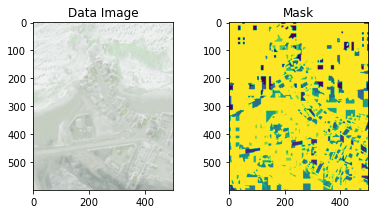

In [18]:
# Reading all data and retrieving labels
data_path = "Boumerdes_dataset"
ids = "Boumerdes"
ids_mask = "gt"

original_image_path = os.path.join(data_path, ids) + ".tif"
mask_path = os.path.join(data_path, ids_mask) + ".png"

original_image = cv2.imread(original_image_path, -1)
mask = cv2.imread(mask_path, 0)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(original_image)
plt.title("Data Image")
ay = fig.add_subplot(1, 2, 2)
ay.imshow(mask)
plt.title("Mask")

In [19]:
samples_labels = list(np.unique(mask))
samples_labels.remove(255)
class_labels = list(range(1,len(samples_labels)+1))
print(samples_labels)

[0, 29, 76, 80, 88, 96, 112, 116, 140, 155, 166, 188, 202]


### Normalization functions

In [20]:
def one_hot_encoder(y):
    nb_classes = len(class_labels)
    nb_samples = len(y)
    one_hot_y = np.zeros((nb_samples, nb_classes), dtype=bool)
    for i in range(0,nb_samples):
        j = int(y[i]-1)
        one_hot_y[i, j] = 1
        
    return one_hot_y

def one_hot_decoder(one_hot_y):
    nb_samples, nb_classes = one_hot_y.shape
    y = np.zeros((nb_samples))
    for i in range(0,nb_samples):
        y[i] = np.where(one_hot_y[i]==1)[0][0] +1
    return y

def normalize_prediction(y_oh_pred):
    nb_samples, nb_classes = y_oh_pred.shape
    y_oh_pred_norm = np.zeros((nb_samples, nb_classes))
    for i in range(0,nb_samples):
        max_pred = np.max(y_oh_pred[i,:])
        j = np.where(y_oh_pred[i]==max_pred)[0][0]
        y_oh_pred_norm[i, j] = 1
    return y_oh_pred_norm

def get_acc(y_ts, y_pred):
    confusion_matrix = np.zeros((len(class_labels), len(class_labels)))
    nb_samples = len(y_ts)
    
    for i in range(0, nb_samples) : 
        actual_class = int(y_ts[i]) - 1
        predicted_class = int(y_pred[i]) - 1

        confusion_matrix[ predicted_class , actual_class ] = confusion_matrix[ predicted_class , actual_class ] + 1
        
    acc_rep = {}
    oa_acc = 0
    aa_acc = 0
    acc_rep["OA"]= 0
    acc_rep["AA"]= 0
    for class_ in range(0, len(class_labels)) :
        if confusion_matrix[class_, class_] == 0:
            acc = 0
        else:
            acc = confusion_matrix[class_,class_]/np.sum(confusion_matrix[:,class_]) * 100

        acc_rep["class " + str(class_ + 1)] = acc
        aa_acc+=acc
        oa_acc+=confusion_matrix[class_,class_]
    acc_rep["OA"]= oa_acc/np.sum(confusion_matrix[:,:])*100
    acc_rep["AA"]= aa_acc/len(class_labels)
    
    return acc_rep

def label2rgb(image_) :
    rgb_labels=[[0,255,255],[102,102,255],[255,0,0],[112,48,160],
            [152,72,6],[150,0,0],[0,176,80],[0,0,252],
            [179,148,0],[10,255,20],[166,166,166],
            [6,174,255],[255,181,168]]
    length, width = np.array(image_).shape
    nbr_channels = 3
    channels = [0,1,2]
    output_image = np.zeros((length, width, nbr_channels))
    for channel in channels :
        layer = np.zeros((length, width))
        for i in class_labels:
            layer[image_==i] = rgb_labels[i-1][channel]
        output_image[:,:,channel] = layer
    return output_image.astype(np.uint8)

### Split train test data

In [21]:
def get_cnn_train_test_data_50_50(image_, mask, denom, window) :
    # this function divided the data 50/50
    train_data = []
    train_mask = []
    test_data = []
    test_mask = []
    c = 1
    for l in samples_labels:
        # samples position
        l_positions = np.where(mask==l)
        i_positions = l_positions[0]
        j_positions = l_positions[1]

        # reference vector for splitting data to train and test
        m2 = np.zeros(len(i_positions),  dtype=bool) # new
        steps = list(range(1,denom,2))
        lengt = len(i_positions) # new
        for i in steps:
            j1 = int(np.round((i/denom)*lengt))
            j2 = int(np.round(((i+1)/denom)*lengt))-1
            m2[j1:j2] = 1

        # train and test patches
        for m in range(len(m2)):
            # get patch
            rad = int(window/2)
            i = i_positions[m]
            j = j_positions[m]
            data_patch = image_[i-rad-1:i+rad,j-rad-1:j+rad,:]
            mask_pixel = c
            # train patches
            if(m2[m] == True):
                train_data.append(data_patch)
                train_mask.append(mask_pixel)
            # test patches
            else:
                test_data.append(data_patch)
                test_mask.append(mask_pixel)
        c+=1
    return train_data, train_mask, test_data, test_mask

def get_svm_train_test_data_50_50(image_, mask, denom) :
    # this function divided the data 50/50
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    c = 1

    for l in samples_labels:
        data = image_[mask==l]
#         denom = 8
        steps = list(range(1,denom,2))
        m2 = np.zeros(len(data),  dtype=bool)
        lengt = len(data)
        for i in steps:
            j1 = int(np.round((i/denom)*lengt))
            j2 = int(np.round(((i+1)/denom)*lengt))-1
            m2[j1:j2] = 1
        train_data.append(data[m2])
        train_labels.append(c*np.ones(len(data[m2])))
        test_data.append(data[~m2])
        test_labels.append(c*np.ones(len(data[~m2])))
        c = c + 1

    X_tr = train_data[0]
    y_tr = train_labels[0]
    X_ts = test_data[0]
    y_ts = test_labels[0]
    for c in class_labels: 
        if c < len(class_labels):
            X_tr = np.concatenate((X_tr, train_data[c]), axis=0)
            y_tr = np.concatenate((y_tr, train_labels[c]), axis=0)
            X_ts = np.concatenate((X_ts, test_data[c]), axis=0)
            y_ts = np.concatenate((y_ts, test_labels[c]), axis=0)
            
    return X_tr, y_tr, X_ts, y_ts

# Haralick Features

In [22]:
def label2idx(L):     
    return [
        np.where(L == i)
        for i in range(1, np.max(L)+1)]

In [23]:
def H_features_calc(A, L, H_properties):
    nRows = A.shape[0]
    nCols = A.shape[1]
    layers = A.shape[2]
    idx = label2idx(L)
    nb_H_props = len(H_properties)
    H_features = np.zeros((nRows, nCols, layers*nb_H_props*4))
#         seg_nbr = 0
    for seg_nbr in range(0, len(idx)):
        seg = np.zeros(A.shape, dtype=np.uint8)
        for i in range(0,layers):
            seg[idx[seg_nbr][0], idx[seg_nbr][1],i] = A[idx[seg_nbr][0], idx[seg_nbr][1],i]

        min_idx_x = min(idx[seg_nbr][0])
        max_idx_x = max(idx[seg_nbr][0])
        min_idx_y = min(idx[seg_nbr][1])
        max_idx_y = max(idx[seg_nbr][1])
        seg = seg[min_idx_x:max_idx_x+1, min_idx_y:max_idx_y+1, :]

        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        for l in range(0,layers):
            glcm = graycomatrix(seg[:,:,l], 
                                distances=distances, 
                                angles=angles, 
            #                     symmetric=True,
            #                     normed=True,
                                levels=np.max(seg[:,:,l])+1)
            glcm[0,:] = 0
            glcm[:,0] = 0
            H_features_seg = np.zeros((nb_H_props, layers))
            for property_id in range(0, nb_H_props):
                H_features_seg[property_id] = graycoprops(glcm, H_properties[property_id])
            H_features[idx[seg_nbr][0], 
                       idx[seg_nbr][1],
                       (l*(nb_H_props*4)):(l+1)*(nb_H_props*4)] = np.array(H_features_seg).flatten(order='C')

    # sklearn normalization method
    H_features_sklearn_norm = copy.deepcopy(H_features)
    scaler = MinMaxScaler(feature_range=(0, 1))
    for k in range(0, H_features_sklearn_norm.shape[2]):
        H_features_sklearn_norm[:,:,k] = scaler.fit_transform(H_features_sklearn_norm[:,:,k])
    
    return H_features_sklearn_norm

# Other functions

In [24]:
def fuse_CNN_H_features(X_tr_HF_of, X_ts_HF_of, X_tr_cnn_features, X_ts_cnn_features):
    # Training
    X_tr_fused_features_cnn_HF_of = []
    for i in range(len(X_tr_HF_of)):
        cnn_features = X_tr_cnn_features[i]
        OF = np.expand_dims(X_tr_HF_of[i], axis=0) 
        fused = np.concatenate((OF,cnn_features), axis=1)
        fused = np.squeeze(fused)
        X_tr_fused_features_cnn_HF_of.append(fused)

    # Testing
    X_ts_fused_features_cnn_HF_of = []
    for i in range(len(X_ts_HF_of)):
        cnn_features = X_ts_cnn_features[i]
        OF = np.expand_dims(X_ts_HF_of[i], axis=0) 
        fused = np.concatenate((OF,cnn_features), axis=1)
        fused = np.squeeze(fused)
        X_ts_fused_features_cnn_HF_of.append(fused)
        
    return X_tr_fused_features_cnn_HF_of, X_ts_fused_features_cnn_HF_of

In [25]:
def sklearn_svm_pred(X_tr, y_tr, X_ts, y_ts):
    
    svm_model  = SVC(kernel='rbf',C=200 ,gamma =2 )
    svm_model.fit(X_tr, y_tr)
    y_pred = svm_model.predict(X_ts)
    
    return y_pred

### parameters

In [26]:
denom=24
LR = 0.0001
epsilon=1e-08
window = 31

##### adding borders to the image

In [27]:
rad = int(window/2)
cnn_image = original_image/255.0
cnn_image_aug = cv2.copyMakeBorder(cnn_image, rad+1, rad+1, rad+1, rad+1, 
                                     cv2.BORDER_REPLICATE, None, value = 0)
mask_aug = 255*np.ones((mask.shape[0] + 2, mask.shape[1] + 2))
mask_aug[1:mask.shape[0] + 1, 1:mask.shape[1] + 1] = mask
mask_aug = cv2.copyMakeBorder(mask_aug, rad, rad, rad, rad, 
                                cv2.BORDER_REPLICATE, None, value = 0)
train_data, train_mask, test_data, test_mask = get_cnn_train_test_data_50_50(cnn_image_aug, 
                                                                                     mask_aug, 
                                                                                     denom, 
                                                                                     window)

# CNN features fusion

## Building the CNN

In [28]:
N_input = train_data[0].shape
N_output =  len(class_labels)

if window == 7:
    model_input = Input(shape=N_input)
    conv_1 = Conv2D(8, (3,3), activation='relu')(model_input)
    maxpool_last = MaxPooling2D(2,2)(conv_1)
    
elif window == 15:
    model_input = Input(shape=N_input)
    conv_1 = Conv2D(8, (3,3), activation='relu')(model_input)
    maxpool_1 = MaxPooling2D(2,2)(conv_1)
    conv_2 = Conv2D(16, (3,3), activation='relu')(maxpool_1)
    maxpool_last = MaxPooling2D(2,2)(conv_2)

elif window == 31:
    model_input = Input(shape=N_input)
    conv_1 = Conv2D(8, (3,3), activation='relu')(model_input)
    maxpool_1 = MaxPooling2D(2,2)(conv_1)
    conv_2 = Conv2D(16, (3,3), activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling2D(2,2)(conv_2)
    conv_3 = Conv2D(32, (3,3), activation='relu')(maxpool_2)
    maxpool_last = MaxPooling2D(2,2)(conv_3)
    
flatten = Flatten()(maxpool_last)

dense_1 = Dense(1024, activation='relu' )(flatten)
dense_2 = Dense(512, activation='relu')(dense_1)  
output = Dense(N_output,activation='softmax')(dense_2)
model = Model(inputs=model_input, outputs=output)

optimizer = Adam(lr=LR, epsilon=epsilon)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31, 31, 4)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 8)         296       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)         

In [29]:
# model.save_weights('CNN_7_initial_weights.h5')

## Training the CNN

In [30]:
train_data = np.array(train_data)
train_mask_OH = one_hot_encoder(train_mask)
train_mask_OH = np.array(train_mask_OH)

In [31]:
nb_epochs = 100

In [32]:
history = model.fit(x=train_data, y=train_mask_OH, epochs=nb_epochs)

Epoch 1/100
791/791 [==============================] - 8s 10ms/step - loss: 0.1865 - accuracy: 0.4481
Epoch 2/100
791/791 [==============================] - 8s 10ms/step - loss: 0.1208 - accuracy: 0.6553
Epoch 3/100
791/791 [==============================] - 8s 10ms/step - loss: 0.1064 - accuracy: 0.6950
Epoch 4/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0997 - accuracy: 0.7147
Epoch 5/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0947 - accuracy: 0.7331
Epoch 6/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0899 - accuracy: 0.7478
Epoch 7/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0856 - accuracy: 0.7633
Epoch 8/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0818 - accuracy: 0.7742
Epoch 9/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0778 - accuracy: 0.7874
Epoch 10/100
791/791 [==============================] - 8s 10ms/step - loss: 0.074

791/791 [==============================] - 8s 10ms/step - loss: 0.0050 - accuracy: 0.9890
Epoch 81/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0046 - accuracy: 0.9898
Epoch 82/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0049 - accuracy: 0.9891
Epoch 83/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0045 - accuracy: 0.9902
Epoch 84/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0057 - accuracy: 0.9873
Epoch 85/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0044 - accuracy: 0.9901
Epoch 86/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0048 - accuracy: 0.9885
Epoch 87/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0048 - accuracy: 0.9880
Epoch 88/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0045 - accuracy: 0.9901
Epoch 89/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0045 - 

## CNN Features extraction

In [33]:
test_data = np.array(test_data)

layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

X_tr_cnn_features = []
for i in range(len(train_data)):
    patch = np.expand_dims(train_data[i], axis=0)
    feature_maps = feature_map_model.predict(patch)
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if layer_name[:7] == "flatten":
            X_tr_cnn_features.append(feature_map)

X_ts_cnn_features = []
for i in range(len(test_data)):
    patch = np.expand_dims(test_data[i], axis=0)
    feature_maps = feature_map_model.predict(patch)
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if layer_name[:7] == "flatten":
            X_ts_cnn_features.append(feature_map)

X_tr_cnn_features = np.array(X_tr_cnn_features)
X_ts_cnn_features = np.array(X_ts_cnn_features)

## normalizing the abstract features
X_tr_cnn_features = X_tr_cnn_features/np.max(X_tr_cnn_features)
X_ts_cnn_features = X_ts_cnn_features/np.max(X_ts_cnn_features)

## Feature fusion and SVM classification

#### Original spectral features (Sf)

In [39]:
X_tr, y_tr, X_ts, y_ts = get_svm_train_test_data_50_50(original_image/255.0, mask, denom)
y_pred_Sf = sklearn_svm_pred(X_tr, y_tr, X_ts, y_ts)
acc_Sf_dict = get_acc(y_ts, y_pred_Sf)
acc_Sf = pd.DataFrame(data=acc_Sf_dict.values(), columns=["Sf (%)"], index=acc_Sf_dict.keys())
acc_Sf

,Sf (%)
OA,67.821164
AA,65.304556
class 1,83.997566
class 2,71.074380
class 3,81.407035
class 4,84.003386
class 5,71.438309
class 6,41.662169
class 7,83.443709
class 8,55.960888


#### Fusion of original spectral features and Haralick features (SHf)

In [40]:
## MSLIC segmentation
params = [47, 96, 62.26295941]
cv_slic = cv2.ximgproc.createSuperpixelSLIC(original_image, algorithm = cv2.ximgproc.MSLIC,
                                            region_size = params[1] , ruler =  params[2])
cv_slic.iterate(params[0])
cv_slic_N = cv_slic.getNumberOfSuperpixels()
segments = cv_slic.getLabels()

## Extracting Haralick features and fusing them with the original spectral features
H_properties=['energy', 'homogeneity']
H_features = H_features_calc(original_image, segments, H_properties)
HF_OF_image = np.concatenate((original_image/255.0, H_features),axis=-1 )

## SVM classification
X_tr_SHf, y_tr, X_ts_SHf, y_ts = get_svm_train_test_data_50_50(HF_OF_image, mask, denom)
y_pred_SHf = sklearn_svm_pred(X_tr_SHf, y_tr, X_ts_SHf, y_ts)
acc_SHf_dict = get_acc(y_ts, y_pred_SHf)
acc_SHf = pd.DataFrame(data=acc_SHf_dict.values(), columns=["SHf (%)"], index=acc_SHf_dict.keys())
acc_SHf

,SHf (%)
OA,84.482624
AA,84.640963
class 1,93.976270
class 2,86.501377
class 3,95.979899
class 4,88.531528
class 5,91.820041
class 6,74.905559
class 7,82.855040
class 8,74.276044


#### Fusion of original spectral features and CNN features (SCf)

In [41]:
## SVM classification
X_tr_Sf, y_tr, X_ts_Sf, y_ts = get_svm_train_test_data_50_50(original_image/255.0, mask, denom)
X_tr_SCf, X_ts_SCf = fuse_CNN_H_features(X_tr_Sf, X_ts_Sf, X_tr_cnn_features, X_ts_cnn_features)
y_pred_SCf = sklearn_svm_pred(X_tr_SCf, y_tr, X_ts_SCf, y_ts)
acc_SCf_dict = get_acc(y_ts, y_pred_SCf)
acc_SCf = pd.DataFrame(data=acc_SCf_dict.values(), columns=["SCf (%)"], index=acc_SCf_dict.keys())
acc_SCf

,SCf (%)
OA,82.194455
AA,82.707813
class 1,89.017341
class 2,81.739473
class 3,94.974874
class 4,89.420229
class 5,89.911384
class 6,78.197518
class 7,82.119205
class 8,71.605867


#### Fusion of original spectral features, Haralick features, and CNN features (SHCf)

In [42]:
## MSLIC segmentation
params = [47, 96, 62.26295941]
cv_slic = cv2.ximgproc.createSuperpixelSLIC(original_image, algorithm = cv2.ximgproc.MSLIC,
                                            region_size = params[1] , ruler =  params[2])
cv_slic.iterate(params[0])
cv_slic_N = cv_slic.getNumberOfSuperpixels()
segments = cv_slic.getLabels()

## Extracting Haralick features and fusing them with the original spectral features
H_properties=['energy', 'homogeneity']
H_features = H_features_calc(original_image, segments, H_properties)
HF_OF_image = np.concatenate((original_image/255.0, H_features),axis=-1 )

## SVM classification
X_tr_SHf, y_tr, X_ts_SHf, y_ts = get_svm_train_test_data_50_50(HF_OF_image, mask, denom)
X_tr_SHCf, X_ts_SHCf = fuse_CNN_H_features(X_tr_SHf, X_ts_SHf, X_tr_cnn_features, X_ts_cnn_features)
y_pred_SHCf = sklearn_svm_pred(X_tr_SHCf, y_tr, X_ts_SHCf, y_ts)
acc_SHCf_dict = get_acc(y_ts, y_pred_SHCf)
acc_SHCf = pd.DataFrame(data=acc_SHCf_dict.values(), columns=["SCHf (%)"], index=acc_SHCf_dict.keys())
acc_SHCf

,SCHf (%)
OA,84.541195
AA,85.041383
class 1,93.398235
class 2,83.746556
class 3,99.246231
class 4,88.319932
class 5,90.456714
class 6,72.261198
class 7,82.045622
class 8,76.006017


#### Accuracy summary comparing all features extraction and features fusion methods

In [43]:
pd.concat([acc_Sf,acc_SHf, acc_SCf, acc_SHCf], axis=1)

,Sf (%),SHf (%),SCf (%),SCHf (%)
OA,67.821164,84.482624,82.194455,84.541195
AA,65.304556,84.640963,82.707813,85.041383
class 1,83.997566,93.976270,89.017341,93.398235
class 2,71.074380,86.501377,81.739473,83.746556
class 3,81.407035,95.979899,94.974874,99.246231
class 4,84.003386,88.531528,89.420229,88.319932
class 5,71.438309,91.820041,89.911384,90.456714
class 6,41.662169,74.905559,78.197518,72.261198
class 7,83.443709,82.855040,82.119205,82.045622
class 8,55.960888,74.276044,71.605867,76.006017
